In [201]:
import os
import numpy as np
import torch
import torch.nn as nn

from bisect import bisect_right
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from python_speech_features import mfcc


class LibriSpeechDataset(Dataset):
    
    def __init__(self, data_dir, word_dir, window_sz=3):
        self.data_dir = data_dir
        self.window_sz = window_sz
        self.npzs = [fn for fn in os.listdir(data_dir) if fn[-4:] == '.npz']
        txts = [fn for fn in os.listdir(word_dir) if fn[-4:] == '.txt']
        self.ptrs = [0]
        self.words = []
                
        ptr_cnt = 0

        for npz in tqdm(self.npzs):
            word_cnt = np.load(os.path.join(data_dir, npz))['word_cnt']
            ptr_cnt += word_cnt
            self.ptrs.append(ptr_cnt)
        for txt in tqdm(txts):
            with open(os.path.join(word_dir, txt), 'r') as f:
                ws = f.read()
                self.words += ws.split()
    
    def __len__(self):
        return self.ptrs[-1] - 2 * self.window_sz
    
    def __getitem__(self, idx):
        ni = bisect_right(self.ptrs, idx)    # locate npz file
        npz = self.npzs[ni - 1]
        data = np.load(os.path.join(self.data_dir, npz))
        
        ds = []
        ws = []
        
        for k in range(2 * self.window_sz + 1):
            # load next npz file if necessary
            if self.ptrs[ni] <= idx + k:
                ni = ni + 1
                npz = self.npzs[ni - 1]
                data = np.load(os.path.join(self.data_dir, npz))
            
            d = data[f'arr_{idx + k - self.ptrs[ni - 1]}']
            d = mfcc(d, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13)
            d = torch.from_numpy(d).float()
            w = self.words[idx + k]
            
            ds.append(d)
            ws.append(w)
            
        src, tgts = ds[self.window_sz], ds[: self.window_sz] + ds[self.window_sz + 1: ]
        src_word, tgt_words = ws[self.window_sz], ws[: self.window_sz] + ws[self.window_sz + 1: ]
        
        
        return {'src': src, 'tgts': tgts, 
                'src_word': src_word, 'tgt_words': tgt_words}
    

    # collate function
    # TODO: PAD vs PACKING be sure of the differences!
    # might need to remember the length of each data
    def pad_collate(self, batch):
        src = [item['src'] for item in batch]
        src = nn.utils.rnn.pack_sequence(src, enforce_sorted=False)
        # src = nn.utils.rnn.pad_sequence(src)
        src_word = [item['src_word'] for item in batch]

        tgts = []
        tgt_words = []
        for i in range(2 * self.window_sz):
            tgt = [item['tgts'][i] for item in batch]
            tgt = nn.utils.rnn.pack_sequence(tgt, enforce_sorted=False)
            # tgt = nn.utils.rnn.pad_sequence(tgt)
            tgt_word = [item['tgt_words'][i] for item in batch]
            
            tgts.append(tgt)
            tgt_words.append(tgt_word)

        return src, tgts, src_word, tgt_words


In [202]:
# 1, 2, 3, 4, 5
# cache
# starting from 1
# if ni is the same than use the cache
# if not than go to next one


# size= total size - 2 * window_sz

# 0, 1, 2, *3*, 4, 5

# do for loop and searhc search?
# having ni, that will give w
# check if next offset is within the ptr range
# if not go to next pointer and stuff


In [203]:
dataset = LibriSpeechDataset('data', 'data_mapping/')
iter_dataloader = iter(DataLoader(dataset, batch_size=2, collate_fn=dataset.pad_collate))


100%|████████████████████████████████████████| 87/87 [00:00<00:00, 18155.35it/s]


In [204]:
import matplotlib.pyplot as plt
# from python_speech_features import mfcc


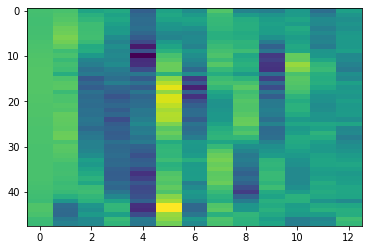

In [215]:
src, tgts, src_word, tgt_words = next(iter_dataloader)

# feat = mfcc(d, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13)
ret = plt.imshow(src[:, 0, :].numpy(), aspect='auto')

In [206]:
tgt_lens

[[tensor(10), tensor(12)],
 [tensor(12), tensor(15)],
 [tensor(15), tensor(9)],
 [tensor(7), tensor(57)],
 [tensor(57), tensor(9)],
 [tensor(9), tensor(35)]]

In [182]:
src_len

[tensor(9), tensor(7)]

In [140]:
tgt_words[0]

['TO', 'CELEBRATE']

In [12]:
%time
next(iter_dataloader)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


tensor([[  48,   25,   34,  ..., 1697, 1222, 1070]], dtype=torch.int16)

In [21]:
import torch
i = 0
while i < 100:
    print(i)
    torch.eq(next(iter_dataloader), torch.tensor(data[f'arr_{next(iter_num)}'])).all()
    i += 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
data = np.load(f'data/{dataset.npzs[1]}')
data['arr_1']

array([-9239, -9466, -9471, ...,   237,   291,   249], dtype=int16)

In [25]:
dataset[624]

array([-9239, -9466, -9471, ...,   237,   291,   249], dtype=int16)

In [19]:
data['word_cnt']

array(721)

In [ ]:
# read all the npy files and check sizes
# let's say they already sorted
# index

# binary search on it
# open the file 

In [ ]:
# if memmap it doesn't make any sense to keep opening files
# just open everything once 
# 